<a href="https://colab.research.google.com/github/Rahulraj31/Diabetic-Retinopathy/blob/main/Diabetic_Retinopathy_224x224_(2019_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
import PIL.Image as Image
import cv2
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

In [3]:
df= pd.read_csv("/content/train.csv")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0 - No_DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferate_DR

In [4]:
from pathlib import Path 
import os
train_data_dir = Path('/content/colored_images')

In [5]:
train_images_dict = {
    'Mild': list(train_data_dir.glob('Mild/*')) ,   
    'Moderate': list(train_data_dir.glob('Moderate/*')),
    'No_DR': list(train_data_dir.glob('No_DR/*')),
    'Proliferate_DR': list(train_data_dir .glob('Proliferate_DR/*')),
    'Severe': list(train_data_dir.glob('Severe/*')),
}

labels_dict = {
     'Mild': 'mild' ,   
    'Moderate':'moderate',
    'No_DR': 'no_dr',
    'Proliferate_DR':'proliferate_dr',
    'Severe': 'sever',
}

In [6]:
img= cv2.imread(str(train_images_dict['Mild'][0]))
img.shape

(224, 224, 3)

In [7]:
X, y = [], []
for name,images in train_images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)

        X.append(img)
        y.append(labels_dict[name])

In [8]:
Fseries = pd.Series(X, name="filepaths",dtype=str)
Lseries = pd.Series(y, name="labels",dtype=str)
data = pd.concat([Fseries,Lseries], axis=1)
dr_df = pd.DataFrame(data)

print(dr_df.head())
print("---------------------")
print(dr_df["labels"].value_counts())


                                       filepaths labels
0  /content/colored_images/Mild/1d11794057ff.png   mild
1  /content/colored_images/Mild/bacfb1029f6b.png   mild
2  /content/colored_images/Mild/7ccb267fd394.png   mild
3  /content/colored_images/Mild/0a3202889f4d.png   mild
4  /content/colored_images/Mild/33ffddea8c6e.png   mild
---------------------
no_dr             1805
moderate           999
mild               370
proliferate_dr     295
sever              193
Name: labels, dtype: int64


In [9]:
val_image_gen = ImageDataGenerator(rescale=1.0/255)

train_image_gen = ImageDataGenerator(rescale            = 1/255,
                                   shear_range        = 0.2,
                                   zoom_range         = 0.2,
                                   horizontal_flip    = True,
                                   rotation_range     = 40,
                                   width_shift_range  = 0.2,
                                   height_shift_range = 0.2)

train = train_image_gen.flow_from_dataframe(dataframe= dr_df,x_col="filepaths",y_col="labels",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False,
                                      subset="training",
                         
                                     )

val = val_image_gen.flow_from_dataframe(dataframe= dr_df,x_col="filepaths",y_col="labels",
                                       target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=2,
                                      subset="validation",
                                      shuffle=False          
                                     )


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [10]:
classes=list(train.class_indices.keys())
print (classes)

['mild', 'moderate', 'no_dr', 'proliferate_dr', 'sever']


In [11]:
from tensorflow.keras.applications import VGG16

cnn_base = VGG16(include_top = False,
                 weights = "imagenet",
                 input_shape = (224, 224, 3),
                 classes = 5,
                 pooling="max",
                 classifier_activation = 'softmax')

cnn_base.trainable = False

In [12]:
pretrainedCNN_model = Sequential([
                                  cnn_base,
                                  layers.Flatten(),
                                  layers.Dense(1000, activation = 'relu'),
                                 
                                  layers.Dense(500, activation = 'relu'),
                                   layers.Dropout(0.25),
                                  layers.Dense(100, activation = 'relu'),
                                  layers.Dense(5, activation = 'softmax')  ,  
])

In [13]:
pretrainedCNN_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
pretrainedCNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              513000    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5

In [15]:
History = pretrainedCNN_model.fit(train, validation_data=val, epochs=10,verbose=1,
                                  )

Epoch 1/10
733/733 [==============================] - 36s 40ms/step - loss: 2.0678 - accuracy: 0.6990 - val_loss: 4.6136 - val_accuracy: 0.4262
Epoch 2/10
733/733 [==============================] - 27s 37ms/step - loss: 0.5816 - accuracy: 0.7747 - val_loss: 5.3372 - val_accuracy: 0.1708
Epoch 3/10
733/733 [==============================] - 27s 37ms/step - loss: 0.5402 - accuracy: 0.7850 - val_loss: 7.5513 - val_accuracy: 0.0642
Epoch 4/10
733/733 [==============================] - 27s 37ms/step - loss: 0.4821 - accuracy: 0.7939 - val_loss: 10.9473 - val_accuracy: 0.4590
Epoch 5/10
733/733 [==============================] - 27s 37ms/step - loss: 0.5347 - accuracy: 0.7874 - val_loss: 12.8822 - val_accuracy: 0.4781
Epoch 6/10
733/733 [==============================] - 27s 37ms/step - loss: 0.4633 - accuracy: 0.8068 - val_loss: 14.0304 - val_accuracy: 0.4249
Epoch 7/10
733/733 [==============================] - 27s 37ms/step - loss: 0.4900 - accuracy: 0.7973 - val_loss: 15.8247 - val_accur

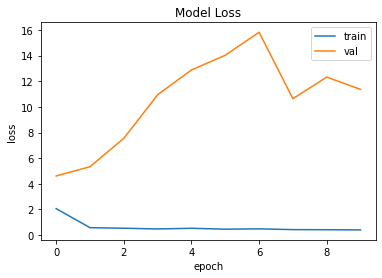

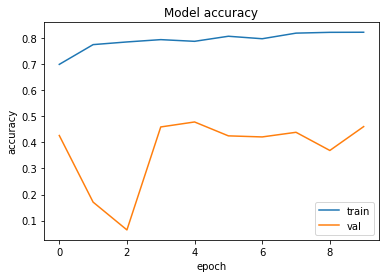

In [16]:
# plot the loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# plot the accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()